## Off-target frequency simulations with no on-target spots

In [2]:
import numpy as np
import pandas as pd
import pyro
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.patches import Circle
from matplotlib.ticker import FormatStrFormatter
from pathlib import Path
from pyro.ops.stats import hpdi, quantile

from tapqir.models import Cosmos

### Load results

In [3]:
EXAMLES_DIR = Path.cwd().resolve().parent.parent.parent / "examples" / "data"

In [4]:
truth = {}
fit = {}
predictions = defaultdict(dict)
models = {}
for data_path in EXAMLES_DIR.iterdir():
    if data_path.is_dir() and data_path.name.startswith("negative"):
        truth[data_path.name] = pd.read_csv(
            data_path / "simulated_params.csv",
            squeeze=True, index_col=0
        ).rename(data_path.name)
        
        param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs4/"
        
        fit[data_path.name] = pd.read_csv(
            param_path / "global_params.csv",
            squeeze=True,
            index_col=0
        ).rename(data_path.name)
        fit[data_path.name]["height"] = truth[data_path.name]["height"]
        
        models[data_path.name] = Cosmos()
        models[data_path.name].load(data_path, True, "cpu")
        models[data_path.name].load_parameters(param_path)
        predictions[data_path.name]["z_all"] = models[data_path.name].z_marginal.flatten()
        mask = torch.from_numpy(models[data_path.name].data.labels["z"])
        samples = torch.masked_select(models[data_path.name].z_marginal, mask)
        predictions[data_path.name]["z_masked"] = samples
        predictions[data_path.name]["z_all"] = models[data_path.name].z_marginal.flatten()

In [5]:
truth_df = pd.concat(truth.values(), axis=1).T
truth_df = truth_df.sort_values(by="rate_j")
truth_df

,gain,probs_z,rate_j,proximity,offset,height,background
negative5,7.0,0.0,0.05,0.2,90.0,3000.0,150.0
negative15,7.0,0.0,0.15,0.2,90.0,3000.0,150.0
negative50,7.0,0.0,0.50,0.2,90.0,3000.0,150.0
negative100,7.0,0.0,1.00,0.2,90.0,3000.0,150.0


In [6]:
fit_df = pd.concat(fit.values(), axis=1).T
fit_df = fit_df.sort_values(by="rate_j").drop(
    ["width_mean_0", "width_size_0", "height_scale", "height"],
    axis=1
)
fit_df

,-ELBO,proximity_0,gain,probs_z_0,probs_z_1,rate_j,MCC,Recall,Precision,FN,TP,TN,FP
negative5,4810234.5,2.000000,7.017624,0.999344,6.561108e-04,0.047847,0.0,0.0,0.0,0.0,0.0,2499.0,1.0
negative15,4824391.5,2.000000,7.019970,0.997548,2.452070e-03,0.144302,0.0,0.0,0.0,0.0,0.0,2499.0,1.0
negative50,4885848.0,1.999880,7.034564,1.000000,5.737187e-08,0.502510,0.0,0.0,0.0,0.0,0.0,2499.0,1.0
negative100,4961365.5,1.999964,7.075340,1.000000,5.862764e-08,0.973410,0.0,0.0,0.0,0.0,0.0,2498.0,2.0


### Figure 4

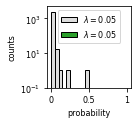

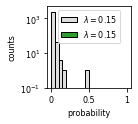

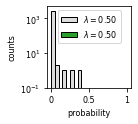

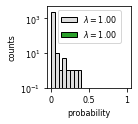

In [8]:
for name in fit_df.index:
    plt.figure(figsize=(1.5, 1.5))
    plt.hist(predictions[name]["z_all"].numpy(),
             bins=np.arange(0, 1.05, 0.05), histtype="bar", lw=1.,
             color="#dddddd", edgecolor="k",
             label=fr"$\lambda=${truth_df.loc[name, 'rate_j']:.2f}")
    plt.hist(predictions[name]["z_masked"].numpy(),
             bins=np.arange(0, 1.05, 0.05), histtype="bar", lw=1.,
             color="C2", edgecolor="k",
             label=fr"$\lambda=${truth_df.loc[name, 'rate_j']:.2f}")
    plt.yscale("log")
    plt.xlim(-0.05,1.05)
    plt.ylim(1e-1, 5e3)
    plt.xticks([0, 0.5, 1], fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylabel("counts", fontsize=8)
    plt.xlabel("probability", fontsize=8)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.legend(loc="upper center", fontsize=8)
    plt.savefig(f"/tmp/logdensity-{name}.svg")
    plt.show()

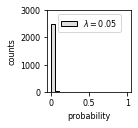

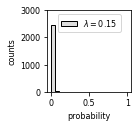

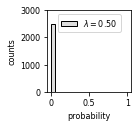

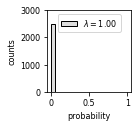

In [7]:
for name in fit_df.index:
    plt.figure(figsize=(1.5, 1.5))
    plt.hist(predictions[name]["z_all"].numpy(),
             bins=np.arange(0, 1.05, 0.05), histtype="bar", lw=1.,
             color="#dddddd", edgecolor="k",
             label=fr"$\lambda=${truth_df.loc[name, 'rate_j']:.2f}")
    plt.xlim(-0.05, 1.05)
    plt.ylim(0, 3000)
    plt.xticks([0, 0.5, 1], fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylabel("counts", fontsize=8)
    plt.xlabel("probability", fontsize=8)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.legend(loc="upper center", fontsize=8)
    plt.savefig(f"/tmp/density-{name}.svg")
    plt.show()

### Analysis

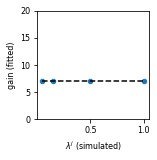

In [8]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["rate_j"].sort_values(), truth_df["gain"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["gain"], s=20)
plt.ylim(0, 20)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\lambda^j$ (simulated)", fontsize=8)
plt.ylabel("gain (fitted)", fontsize=8)
plt.show()

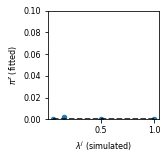

In [9]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["rate_j"].sort_values(), truth_df["probs_z"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["probs_z_1"], s=20)
plt.ylim(0, 0.1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\lambda^j$ (simulated)", fontsize=8)
plt.ylabel(r"$\pi^z$ (fitted)", fontsize=8)
plt.show()

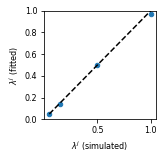

In [10]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["rate_j"].sort_values(), truth_df["rate_j"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["rate_j"], s=20)
plt.ylim(0, 1.)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\lambda^j$ (simulated)", fontsize=8)
plt.ylabel(r"$\lambda^j$ (fitted)", fontsize=8)
plt.show()

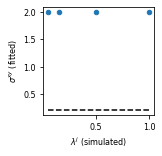

In [11]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["rate_j"].sort_values(), truth_df["proximity"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["proximity_0"], s=20)
# plt.ylim(0., 0.6)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\lambda^j$ (simulated)", fontsize=8)
plt.ylabel(r"$\sigma^{xy}$ (fitted)", fontsize=8)
plt.show()